# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

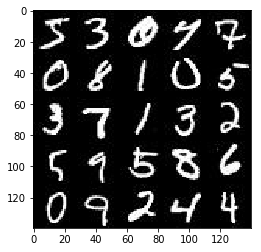

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

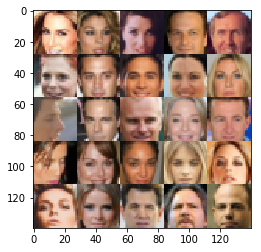

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\Development\Anaconda\envs\Udacity\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x224

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x448 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x224 now

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x112 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim now

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.1
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    # label smoothing
    d_model_real_labels = tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)
    d_model_fake_labels = tf.ones_like(d_model_fake) * np.random.uniform(0.0, 0.3)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_model_real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_model_fake_labels))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    show_every=100
    print_every=10
    n_images = 25

    samples, losses = [], []
    steps = 0
    
    input_real, input_z, learning_rate2 = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: -0.9728... Generator Loss: 2.0606
Epoch 1/2... Discriminator Loss: -1.1247... Generator Loss: 1.7808
Epoch 1/2... Discriminator Loss: -0.0491... Generator Loss: 0.3657
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 3.7258
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 1.1681
Epoch 1/2... Discriminator Loss: 2.0165... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.2123
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 0.3241
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 0.8412


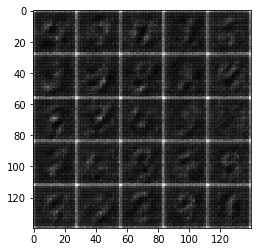

Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 0.2090
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.1212
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.1029
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.1390
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 0.5052
Epoch 1/2... Discriminator Loss: 0.4657... Generator Loss: 1.1153
Epoch 1/2... Discriminator Loss: 0.6124... Generator Loss: 0.9163
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 0.4788


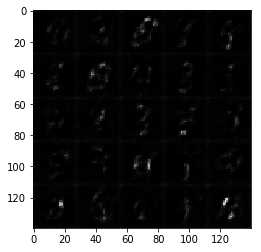

Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 0.2647
Epoch 1/2... Discriminator Loss: 0.6019... Generator Loss: 0.2841
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 0.7476... Generator Loss: 0.2551
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 0.1877
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 0.4189
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.1510
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.1295
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.0714


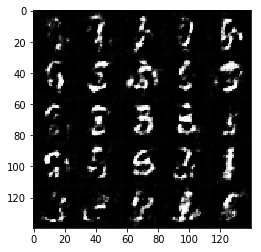

Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 0.1933
Epoch 1/2... Discriminator Loss: 0.1944... Generator Loss: 1.0513
Epoch 1/2... Discriminator Loss: 0.2777... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 0.3823
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.1308
Epoch 1/2... Discriminator Loss: 0.4181... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 0.1349... Generator Loss: 2.0347
Epoch 1/2... Discriminator Loss: 0.3734... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 0.0994
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.1406


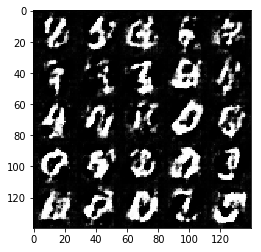

Epoch 1/2... Discriminator Loss: 2.7042... Generator Loss: 0.0307
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 2.0130... Generator Loss: 0.0578
Epoch 1/2... Discriminator Loss: 1.7543... Generator Loss: 0.0489
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 0.2297
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 2.9835
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.1820
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.9381... Generator Loss: 0.0425
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.1140


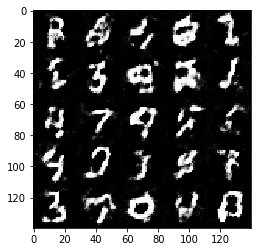

Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 0.5279... Generator Loss: 1.3930
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 0.2875
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.1403
Epoch 1/2... Discriminator Loss: 1.8429... Generator Loss: 0.0454
Epoch 1/2... Discriminator Loss: 1.5423... Generator Loss: 0.1681
Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.4124... Generator Loss: 0.3677
Epoch 1/2... Discriminator Loss: 0.4511... Generator Loss: 0.3817
Epoch 1/2... Discriminator Loss: 0.6702... Generator Loss: 2.2530


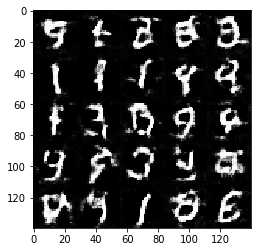

Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 0.2014
Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.0781
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.1041
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.1599
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.0704
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 0.2631
Epoch 1/2... Discriminator Loss: 0.3600... Generator Loss: 1.3670
Epoch 1/2... Discriminator Loss: 1.2156... Generator Loss: 0.1533
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 0.2122
Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 0.2262


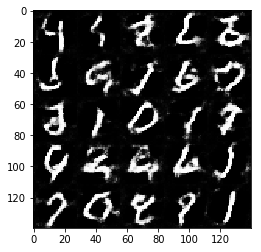

Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.1140
Epoch 1/2... Discriminator Loss: 1.7695... Generator Loss: 0.0684
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.1203
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 0.3627
Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 1.6436
Epoch 1/2... Discriminator Loss: -0.0331... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 0.3343... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 2.2075
Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.1379


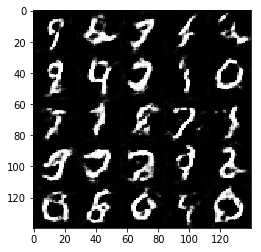

Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 0.2657
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.1259
Epoch 1/2... Discriminator Loss: 1.5568... Generator Loss: 0.0638
Epoch 1/2... Discriminator Loss: 0.0985... Generator Loss: 0.9551
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.1481
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.0782
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.0997
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.2123
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.0704
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.2432


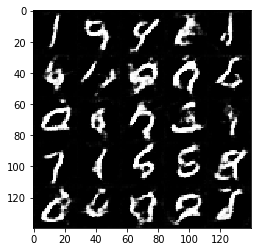

Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.1002
Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.1281
Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.0659
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.2202
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.1748
Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.3982
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 0.3904


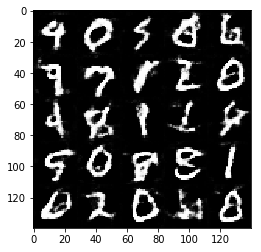

Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 1.6639
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.1092
Epoch 1/2... Discriminator Loss: 1.8767... Generator Loss: 0.0681
Epoch 1/2... Discriminator Loss: 1.7992... Generator Loss: 0.0729
Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 0.2787... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 0.1155... Generator Loss: 1.7877
Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 0.3411
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.0995
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 0.3883


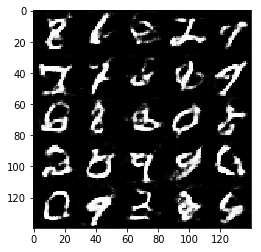

Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 1.5539
Epoch 1/2... Discriminator Loss: 0.2013... Generator Loss: 1.8759
Epoch 1/2... Discriminator Loss: 0.7792... Generator Loss: 0.2861
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.0978
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.1116
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.1822
Epoch 1/2... Discriminator Loss: 0.6948... Generator Loss: 0.3711
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.1403
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.1075


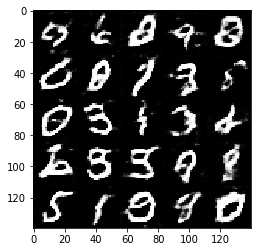

Epoch 1/2... Discriminator Loss: 0.3604... Generator Loss: 1.2524
Epoch 1/2... Discriminator Loss: 0.3751... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.0980
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.1686
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 0.5992... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 0.4935
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.1237
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 0.5020


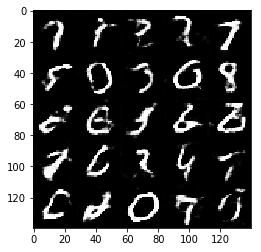

Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 0.4221
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.1791
Epoch 1/2... Discriminator Loss: 1.0101... Generator Loss: 0.1540
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.1487
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 1.4096
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 0.3127
Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 1.9032
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.1266
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.1364
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 0.3405


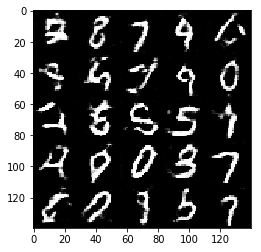

Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 0.4296
Epoch 1/2... Discriminator Loss: 0.3048... Generator Loss: 1.5878
Epoch 1/2... Discriminator Loss: 0.0227... Generator Loss: 1.3409
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.1270
Epoch 1/2... Discriminator Loss: 1.4931... Generator Loss: 0.0807
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.1782
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.0492
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.1306
Epoch 1/2... Discriminator Loss: 1.8309... Generator Loss: 0.0441
Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 0.1805


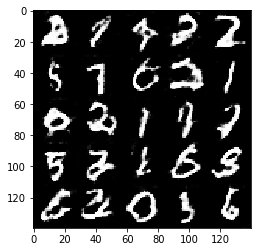

Epoch 1/2... Discriminator Loss: 1.6588... Generator Loss: 0.0595
Epoch 1/2... Discriminator Loss: 1.5104... Generator Loss: 0.0986
Epoch 1/2... Discriminator Loss: 1.8314... Generator Loss: 0.0386
Epoch 1/2... Discriminator Loss: -0.0498... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 0.4789... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.7308... Generator Loss: 0.0652
Epoch 1/2... Discriminator Loss: 1.6190... Generator Loss: 0.0602
Epoch 1/2... Discriminator Loss: 2.0546... Generator Loss: 0.0290
Epoch 1/2... Discriminator Loss: 0.0863... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.8864... Generator Loss: 0.0661


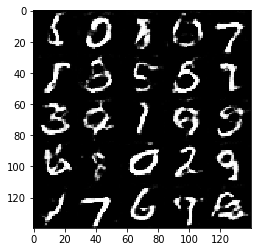

Epoch 1/2... Discriminator Loss: 1.7319... Generator Loss: 0.0842
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 0.0739
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.0575
Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.1757
Epoch 1/2... Discriminator Loss: 1.4838... Generator Loss: 0.0631
Epoch 1/2... Discriminator Loss: 2.0750... Generator Loss: 0.0560
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.1469
Epoch 1/2... Discriminator Loss: 0.5222... Generator Loss: 0.1419
Epoch 1/2... Discriminator Loss: 0.1295... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 0.6124


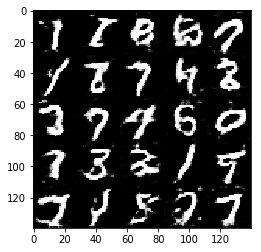

Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 0.2991
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.0371
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.1127
Epoch 1/2... Discriminator Loss: 0.2240... Generator Loss: 2.3725
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.0482
Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 0.1353... Generator Loss: 1.8291
Epoch 1/2... Discriminator Loss: -0.0884... Generator Loss: 1.3929
Epoch 1/2... Discriminator Loss: 1.8004... Generator Loss: 0.0567
Epoch 1/2... Discriminator Loss: -0.1624... Generator Loss: 1.1631


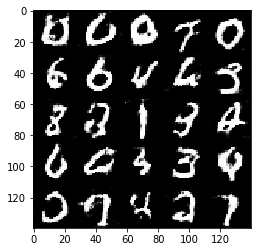

Epoch 1/2... Discriminator Loss: 0.0843... Generator Loss: 1.3940
Epoch 1/2... Discriminator Loss: 1.8408... Generator Loss: 0.0384
Epoch 1/2... Discriminator Loss: 1.5429... Generator Loss: 0.1039
Epoch 1/2... Discriminator Loss: 0.6127... Generator Loss: 0.2634
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.1447
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 0.3187
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 0.1589
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 0.2535
Epoch 2/2... Discriminator Loss: -0.3016... Generator Loss: 1.1113
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.1496


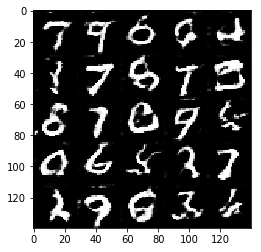

Epoch 2/2... Discriminator Loss: 0.2180... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 0.6282... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 0.2745
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.1517
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 0.2451
Epoch 2/2... Discriminator Loss: 0.2765... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 0.3804
Epoch 2/2... Discriminator Loss: 0.0535... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.0116... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 0.2114... Generator Loss: 0.7534


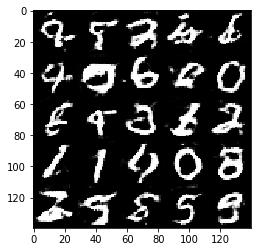

Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.1975
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 0.1638
Epoch 2/2... Discriminator Loss: 0.1874... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: -0.1812... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.8580... Generator Loss: 0.0531
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.1345
Epoch 2/2... Discriminator Loss: 1.9580... Generator Loss: 0.0415
Epoch 2/2... Discriminator Loss: 0.0202... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: -0.1326... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 0.0424... Generator Loss: 1.0959


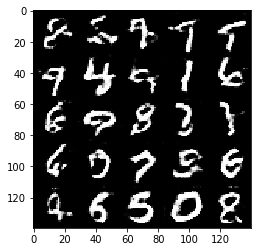

Epoch 2/2... Discriminator Loss: 0.6318... Generator Loss: 0.4835
Epoch 2/2... Discriminator Loss: 1.6932... Generator Loss: 4.3884
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 0.1557
Epoch 2/2... Discriminator Loss: 0.6719... Generator Loss: 0.4397
Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 2.1173
Epoch 2/2... Discriminator Loss: 0.3288... Generator Loss: 0.5122
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.0855
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 0.2431
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 0.2776
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.1231


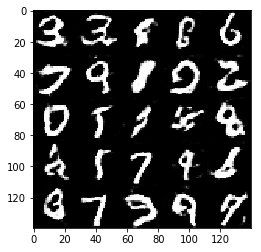

Epoch 2/2... Discriminator Loss: 1.6672... Generator Loss: 0.0683
Epoch 2/2... Discriminator Loss: -0.5646... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: -0.0733... Generator Loss: 1.5905
Epoch 2/2... Discriminator Loss: -0.0789... Generator Loss: 1.7113
Epoch 2/2... Discriminator Loss: 0.2863... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 0.2550
Epoch 2/2... Discriminator Loss: 0.4596... Generator Loss: 0.5283
Epoch 2/2... Discriminator Loss: 0.0378... Generator Loss: 0.5650
Epoch 2/2... Discriminator Loss: -0.2671... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.1093


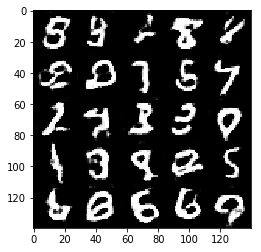

Epoch 2/2... Discriminator Loss: -0.2251... Generator Loss: 2.6420
Epoch 2/2... Discriminator Loss: 0.5513... Generator Loss: 2.6497
Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.0336
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 0.3763
Epoch 2/2... Discriminator Loss: 0.5684... Generator Loss: 0.5069
Epoch 2/2... Discriminator Loss: -0.2202... Generator Loss: 1.9670
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 0.2454
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 0.3304
Epoch 2/2... Discriminator Loss: -0.5985... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 0.5073... Generator Loss: 0.2969


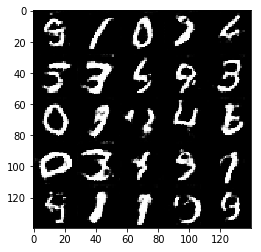

Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 0.1890
Epoch 2/2... Discriminator Loss: -0.1296... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 0.3153
Epoch 2/2... Discriminator Loss: 0.1126... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 0.2821
Epoch 2/2... Discriminator Loss: 0.0269... Generator Loss: 2.9712
Epoch 2/2... Discriminator Loss: 0.2712... Generator Loss: 2.4282
Epoch 2/2... Discriminator Loss: 0.4591... Generator Loss: 0.2749
Epoch 2/2... Discriminator Loss: 1.5874... Generator Loss: 0.0668
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.0933


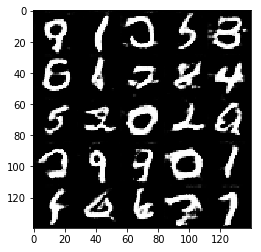

Epoch 2/2... Discriminator Loss: -0.0666... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: -0.4728... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.7141... Generator Loss: 0.0515
Epoch 2/2... Discriminator Loss: -0.2759... Generator Loss: 1.0975
Epoch 2/2... Discriminator Loss: 1.8916... Generator Loss: 0.1050
Epoch 2/2... Discriminator Loss: 1.7849... Generator Loss: 0.1052
Epoch 2/2... Discriminator Loss: 0.5679... Generator Loss: 0.3809
Epoch 2/2... Discriminator Loss: 0.0405... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 0.1012... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 0.2588


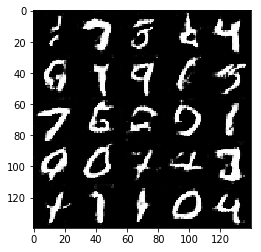

Epoch 2/2... Discriminator Loss: 1.8819... Generator Loss: 0.0469
Epoch 2/2... Discriminator Loss: 0.2500... Generator Loss: 0.3785
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 0.2204
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.1615
Epoch 2/2... Discriminator Loss: 1.9562... Generator Loss: 0.0321
Epoch 2/2... Discriminator Loss: -0.9136... Generator Loss: 1.5457
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 0.3524
Epoch 2/2... Discriminator Loss: 0.6082... Generator Loss: 0.2853
Epoch 2/2... Discriminator Loss: -0.5997... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 0.4508... Generator Loss: 1.6871


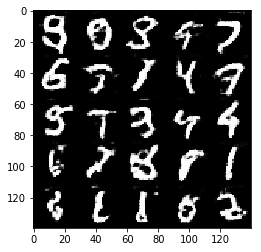

Epoch 2/2... Discriminator Loss: 0.2699... Generator Loss: 0.2588
Epoch 2/2... Discriminator Loss: 0.2809... Generator Loss: 0.8779
Epoch 2/2... Discriminator Loss: 0.1217... Generator Loss: 1.8722
Epoch 2/2... Discriminator Loss: 0.3600... Generator Loss: 0.3015
Epoch 2/2... Discriminator Loss: 0.1603... Generator Loss: 0.2346
Epoch 2/2... Discriminator Loss: 0.3009... Generator Loss: 0.9433
Epoch 2/2... Discriminator Loss: -0.4123... Generator Loss: 1.7195
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 0.1567
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 0.2421
Epoch 2/2... Discriminator Loss: 0.3115... Generator Loss: 0.3316


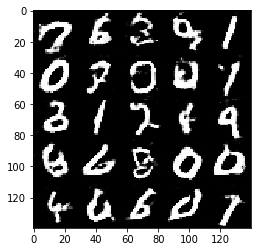

Epoch 2/2... Discriminator Loss: -0.0893... Generator Loss: 1.5801
Epoch 2/2... Discriminator Loss: -0.0812... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 0.5700... Generator Loss: 0.2296
Epoch 2/2... Discriminator Loss: -0.1966... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: -0.3848... Generator Loss: 1.2425
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 0.1110
Epoch 2/2... Discriminator Loss: 0.0639... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: -0.7619... Generator Loss: 1.0490
Epoch 2/2... Discriminator Loss: 0.3649... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: -0.0624... Generator Loss: 2.0854


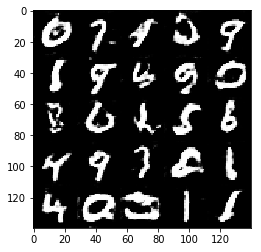

Epoch 2/2... Discriminator Loss: -0.1296... Generator Loss: 2.2107
Epoch 2/2... Discriminator Loss: 0.6302... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: -0.7230... Generator Loss: 1.3191
Epoch 2/2... Discriminator Loss: -0.2831... Generator Loss: 2.5055
Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 0.0957
Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 0.2486
Epoch 2/2... Discriminator Loss: -0.8808... Generator Loss: 1.0109
Epoch 2/2... Discriminator Loss: 2.0844... Generator Loss: 0.0546
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 0.1945
Epoch 2/2... Discriminator Loss: 0.1122... Generator Loss: 1.9480


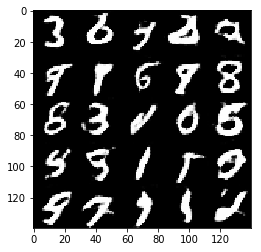

Epoch 2/2... Discriminator Loss: 1.7461... Generator Loss: 0.0465
Epoch 2/2... Discriminator Loss: 1.9738... Generator Loss: 0.0264
Epoch 2/2... Discriminator Loss: 2.5333... Generator Loss: 0.0374
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.1017
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.1541
Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 0.1599
Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 0.2092
Epoch 2/2... Discriminator Loss: 1.1627... Generator Loss: 0.1360
Epoch 2/2... Discriminator Loss: 2.6583... Generator Loss: 0.0166
Epoch 2/2... Discriminator Loss: 0.4238... Generator Loss: 0.4263


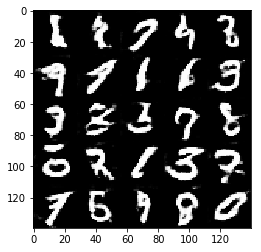

Epoch 2/2... Discriminator Loss: -0.7552... Generator Loss: 3.1679
Epoch 2/2... Discriminator Loss: 1.5096... Generator Loss: 0.1167
Epoch 2/2... Discriminator Loss: 0.0179... Generator Loss: 1.4574
Epoch 2/2... Discriminator Loss: -0.3823... Generator Loss: 2.1743
Epoch 2/2... Discriminator Loss: 0.3322... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 0.1481
Epoch 2/2... Discriminator Loss: 0.4225... Generator Loss: 0.2457
Epoch 2/2... Discriminator Loss: 1.7323... Generator Loss: 0.1596
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 0.3801
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.0699


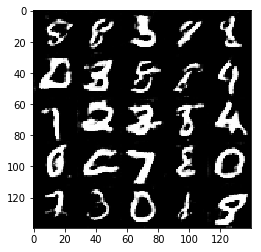

Epoch 2/2... Discriminator Loss: -0.5474... Generator Loss: 1.9837
Epoch 2/2... Discriminator Loss: 2.2305... Generator Loss: 0.0680
Epoch 2/2... Discriminator Loss: -0.1977... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: -0.5317... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 0.4462... Generator Loss: 0.3495
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.1421
Epoch 2/2... Discriminator Loss: -0.1900... Generator Loss: 0.4160
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 2.5932
Epoch 2/2... Discriminator Loss: 2.2657... Generator Loss: 0.1061
Epoch 2/2... Discriminator Loss: 0.4307... Generator Loss: 0.2813


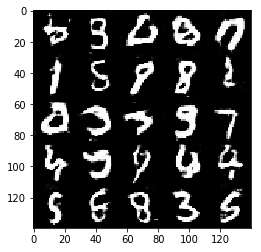

Epoch 2/2... Discriminator Loss: -0.5814... Generator Loss: 1.8029
Epoch 2/2... Discriminator Loss: -0.9095... Generator Loss: 1.4912
Epoch 2/2... Discriminator Loss: -0.6998... Generator Loss: 1.6618
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.1004
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 0.3366
Epoch 2/2... Discriminator Loss: -0.1032... Generator Loss: 0.2511
Epoch 2/2... Discriminator Loss: -0.0361... Generator Loss: 1.5931
Epoch 2/2... Discriminator Loss: 1.7698... Generator Loss: 0.0413
Epoch 2/2... Discriminator Loss: 0.2406... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 2.1166... Generator Loss: 0.1454


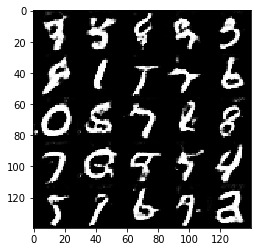

Epoch 2/2... Discriminator Loss: 0.1265... Generator Loss: 1.9435
Epoch 2/2... Discriminator Loss: 0.5596... Generator Loss: 0.3746
Epoch 2/2... Discriminator Loss: 0.5513... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 0.1232... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: -0.3765... Generator Loss: 1.1398
Epoch 2/2... Discriminator Loss: 0.1245... Generator Loss: 0.4510
Epoch 2/2... Discriminator Loss: -1.1066... Generator Loss: 1.9646
Epoch 2/2... Discriminator Loss: 1.1072... Generator Loss: 0.1377
Epoch 2/2... Discriminator Loss: 0.6489... Generator Loss: 4.9860
Epoch 2/2... Discriminator Loss: -0.6561... Generator Loss: 1.3116


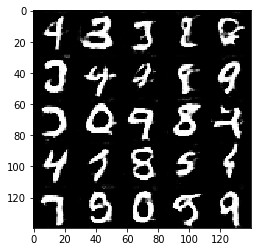

Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.3351
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.1233
Epoch 2/2... Discriminator Loss: 1.7600... Generator Loss: 0.0400
Epoch 2/2... Discriminator Loss: 0.0569... Generator Loss: 0.2317
Epoch 2/2... Discriminator Loss: -0.9037... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.1102
Epoch 2/2... Discriminator Loss: -0.6839... Generator Loss: 1.3989
Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 0.1301
Epoch 2/2... Discriminator Loss: 1.6561... Generator Loss: 0.1300
Epoch 2/2... Discriminator Loss: 1.8700... Generator Loss: 0.0497


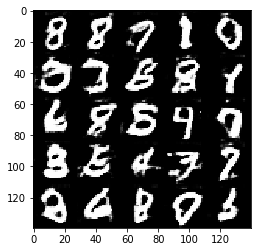

Epoch 2/2... Discriminator Loss: -0.1769... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.1763
Epoch 2/2... Discriminator Loss: 0.0164... Generator Loss: 0.1730
Epoch 2/2... Discriminator Loss: 0.1119... Generator Loss: 0.4686
Epoch 2/2... Discriminator Loss: -0.0087... Generator Loss: 0.3480
Epoch 2/2... Discriminator Loss: -0.2742... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 2.1240... Generator Loss: 0.1021
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 0.1353
Epoch 2/2... Discriminator Loss: 1.7806... Generator Loss: 0.1173
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.1004


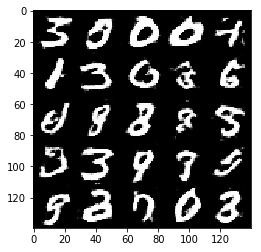

Epoch 2/2... Discriminator Loss: -0.5947... Generator Loss: 3.3465
Epoch 2/2... Discriminator Loss: 0.0659... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: -0.6989... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 0.1194... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: -1.1645... Generator Loss: 1.5411


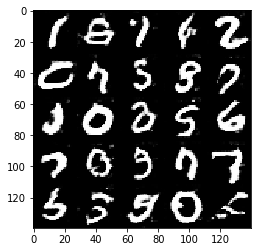

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.0875... Generator Loss: 0.0883
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 2.7232... Generator Loss: 11.6675
Epoch 1/1... Discriminator Loss: 3.1318... Generator Loss: 5.0282
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 2.6851
Epoch 1/1... Discriminator Loss: 2.1387... Generator Loss: 3.6766
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 2.8110... Generator Loss: 0.1462
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 1.6473
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 1.4051


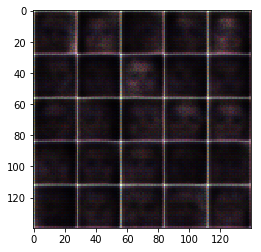

Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 1.3315
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 2.5159
Epoch 1/1... Discriminator Loss: 2.3497... Generator Loss: 3.1376
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.4450


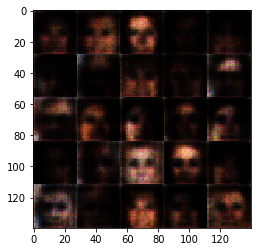

Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.5563
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 2.5908... Generator Loss: 4.7651
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.9619... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 3.2386


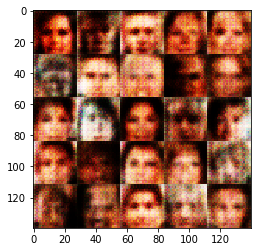

Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 2.5775
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 3.2971


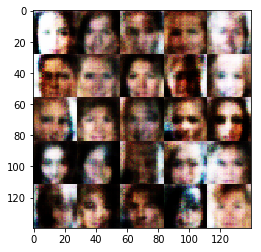

Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 2.0070
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.6280
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.5760
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 2.2085
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.7088
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.3172


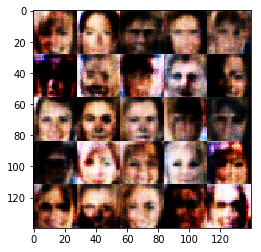

Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 3.7621
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 2.8377
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.3759
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 2.4263
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 3.0173
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 2.8826


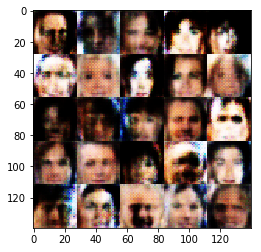

Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 2.0735
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 2.8914
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.9273
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 3.7920
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.4273
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 2.5186


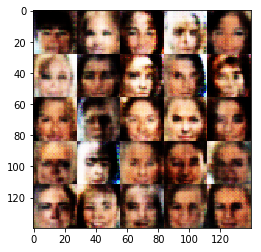

Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.6683
Epoch 1/1... Discriminator Loss: 2.0325... Generator Loss: 0.3140
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.8713
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 2.2024


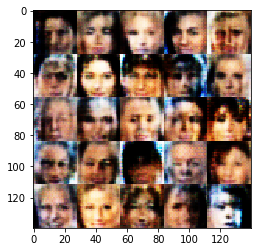

Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.9755
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 2.9518
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 2.6619
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.1317


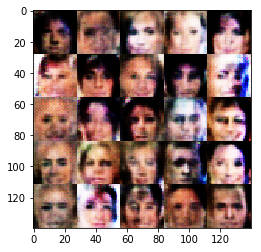

Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.9236
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.6719
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 2.2996
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 2.3558


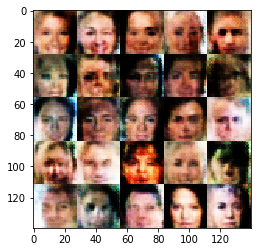

Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.6451
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 2.0567
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 2.5128


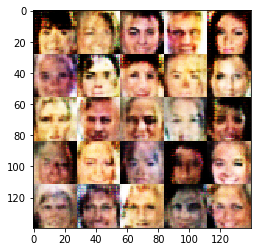

Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.4429
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.7164
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9745


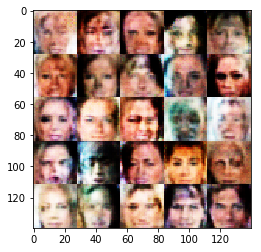

Epoch 1/1... Discriminator Loss: 2.1199... Generator Loss: 0.2748
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 1.9134
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.1264


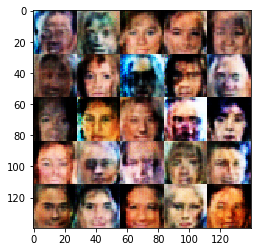

Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 2.0290
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 2.7105
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 2.1205... Generator Loss: 2.2612
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.2845


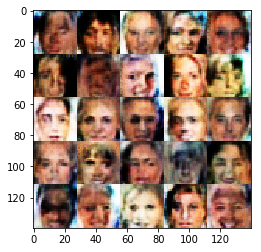

Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.5531
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.6723
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 2.2074
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.6934


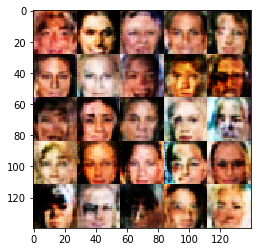

Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 1.9798
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.9991
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.8402


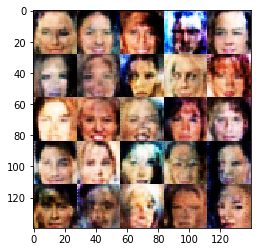

Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 2.4110
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.7037


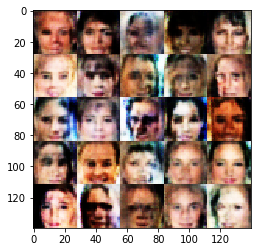

Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 1.7658... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 3.0711
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 2.5402
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.6728... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 2.5481
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 1.6063


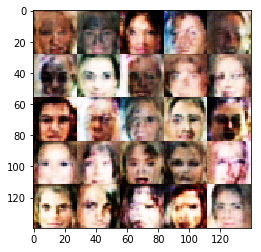

Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 2.0275
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.9224
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 2.3154
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 2.2797
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6859


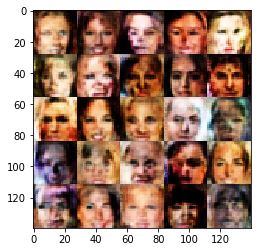

Epoch 1/1... Discriminator Loss: 2.1754... Generator Loss: 2.1552
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.6785... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.9583
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 2.1105
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.2363


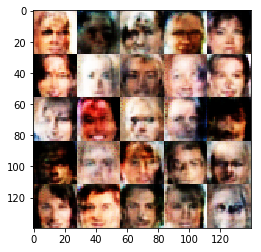

Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 2.1852
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.2752
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.8610
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 3.9796
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.4667
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 2.3913
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0967


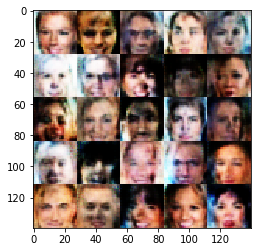

Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 2.9605
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 2.2837
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.8256
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.6213... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 2.0601


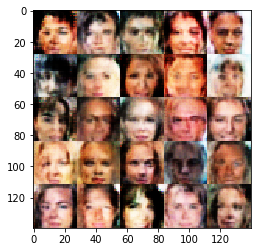

Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.7812
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 2.6842
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.5423
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.8622
Epoch 1/1... Discriminator Loss: 1.9807... Generator Loss: 2.7855
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 2.1480


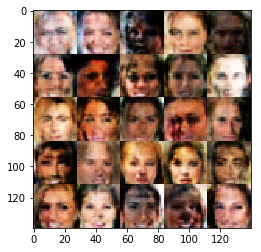

Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.9696
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 2.4904
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.8262
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 2.3970
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 1.7762... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 1.9532
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 2.3740


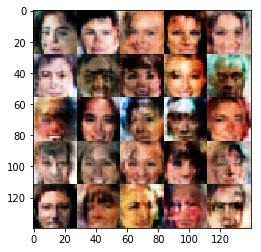

Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 2.0965
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 2.2610
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 1.7749... Generator Loss: 2.8135
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7709


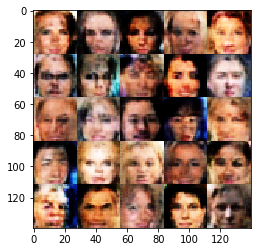

Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 2.2934
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.3309
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 2.5990
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 2.1325
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 2.9486
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.6416
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 2.0296


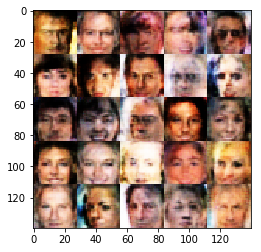

Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.9558
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.9451
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.9794... Generator Loss: 3.7885
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 2.6893
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 2.5597
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 2.6938
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.7562
Epoch 1/1... Discriminator Loss: 1.9440... Generator Loss: 2.8992


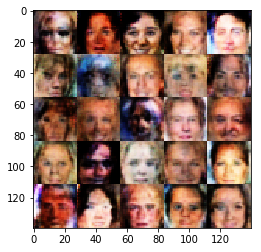

Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 2.0860
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.7660
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 2.3602
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 2.0245
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.1560


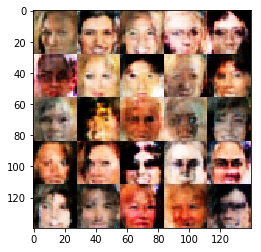

Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.7170
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.9703
Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 2.0797
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 2.2717
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 2.4296
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.4953
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.3550
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.3685


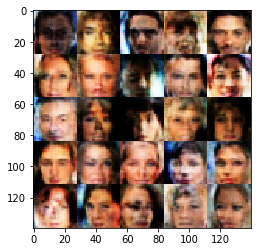

Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 2.3403
Epoch 1/1... Discriminator Loss: 1.7509... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 2.4436
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.6383
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 2.5594
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.6794
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.4933
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.1558


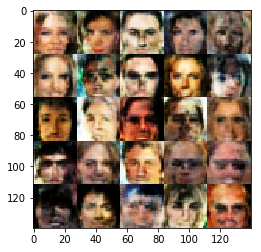

Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.6614
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 2.2752
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.4277
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 2.9321


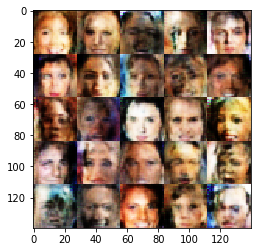

Epoch 1/1... Discriminator Loss: 1.8193... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 2.1624
Epoch 1/1... Discriminator Loss: 1.9442... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 3.1341
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.7213
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 2.3215


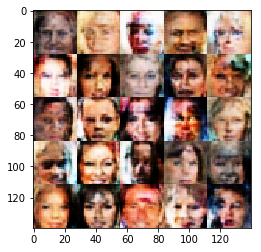

Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 1.9841
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.9059


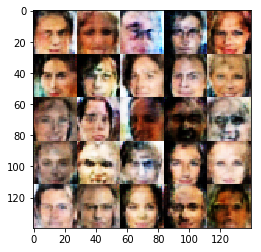

Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 3.1253
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.7894
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 2.4580
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.0665


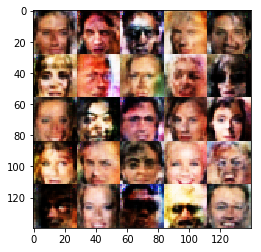

Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.7486
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 2.6042
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 1.9057
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 2.7882
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.4766


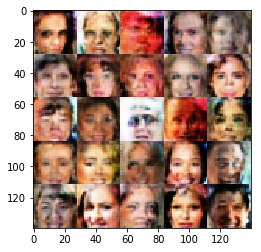

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 2.2720
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.9649
Epoch 1/1... Discriminator Loss: 1.6590... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 2.3857
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 2.9668
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.6632


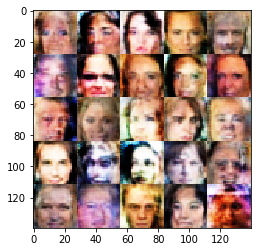

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.7824
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 2.0734
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 2.2012
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 2.9037
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.5500
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 2.0271


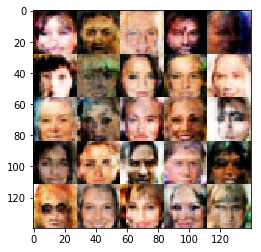

Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.7257
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.9865


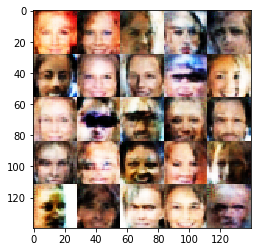

Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 2.4430
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 2.8231
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 2.0916
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.6790
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.4914


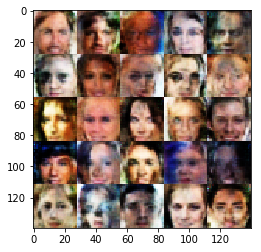

Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 3.1116
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.9854


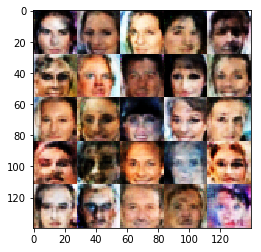

Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 1.7177... Generator Loss: 0.4250


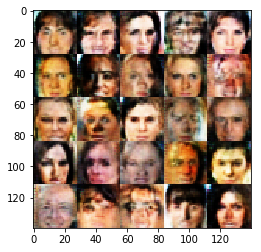

Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 2.2809
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.8220... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 2.9251
Epoch 1/1... Discriminator Loss: 1.8881... Generator Loss: 0.3352


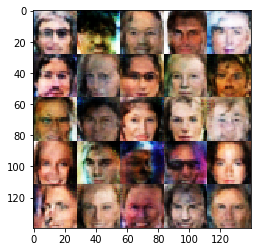

Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.7554
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.8069
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.6309
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.9130
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 2.4969
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 2.0646
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6211


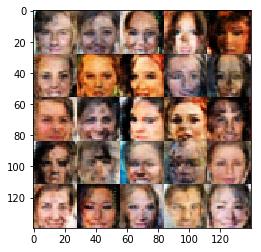

Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.5602
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.8179
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.5650
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 1.8437
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 2.1711
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 2.2200
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.8826


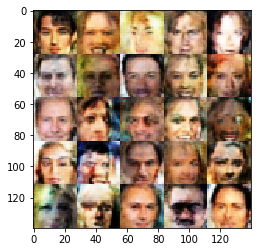

Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.5745
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.8186
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.9062
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 2.2856


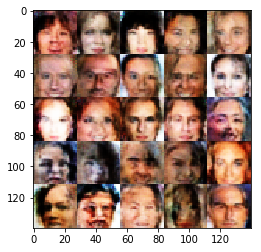

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.8343
Epoch 1/1... Discriminator Loss: 1.8414... Generator Loss: 2.4056
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 2.1041
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 2.5130
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.5937


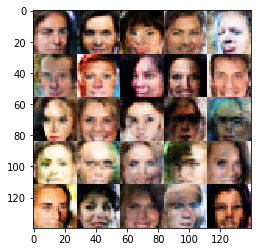

Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 2.3119
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.3832
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 3.1241
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.7073
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 2.1028
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 2.0296


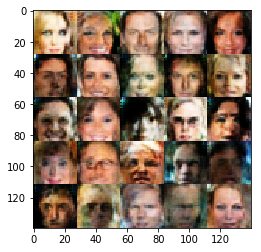

Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 2.5671
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.4869
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.4041
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.9043
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 2.4708
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6576


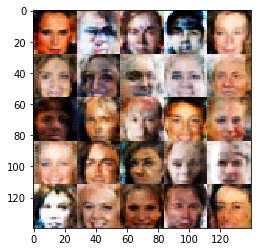

Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.8675
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 2.2729
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.9717
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 1.7200... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 2.3444


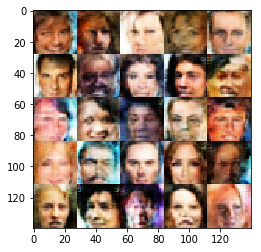

Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 1.6032
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 1.1658
Epoch 1/1... Discriminator Loss: 1.8757... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 2.3429
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 2.1731


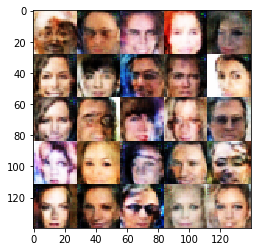

Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.3626
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 2.5096
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.7185
Epoch 1/1... Discriminator Loss: 1.6612... Generator Loss: 2.5466
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 2.1332


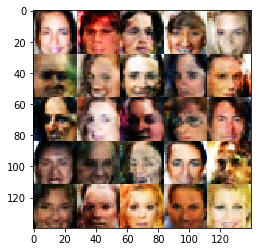

Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 2.8695
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.0700


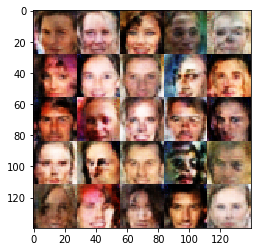

Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.7385... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 2.2220
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.8106
Epoch 1/1... Discriminator Loss: 1.7750... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.2960
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.0907


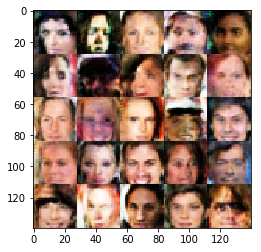

Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.4673
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.3470
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.6368


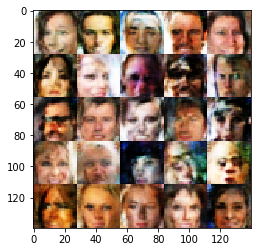

Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 2.4885
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 2.0402
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 2.4708
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.9172


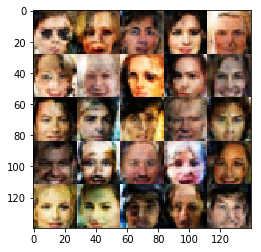

Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 2.5397
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.4853
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 2.5023
Epoch 1/1... Discriminator Loss: 1.9860... Generator Loss: 0.3229
Epoch 1/1... Discriminator Loss: 1.6862... Generator Loss: 2.0011
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 2.4006
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 0.9875


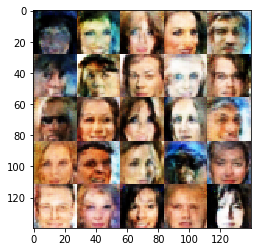

Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.8419... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 1.9139
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.8120
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 2.3703
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.6665


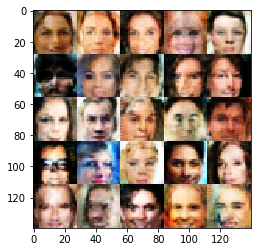

Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 2.3161
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 2.1971
Epoch 1/1... Discriminator Loss: 1.9192... Generator Loss: 0.3253
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 2.0939
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 2.3136
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.4406
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6413


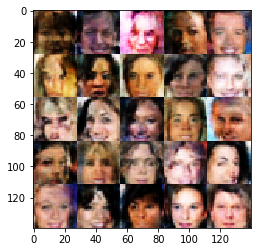

Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 2.4891
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 2.1646
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.6274


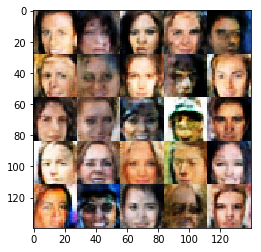

Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.9308
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 2.1912
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 2.7491


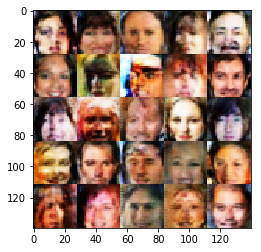

Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.3669
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 1.8490... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 2.1995
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.4377
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 2.0079... Generator Loss: 2.7368
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.7085


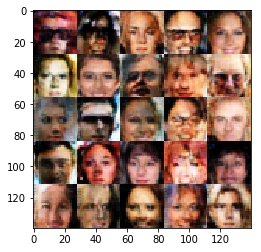

Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.8846
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 1.6333
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.5860
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 2.4056
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 2.0353
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9132


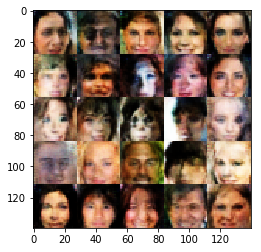

Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.8731
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 1.7237... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6175


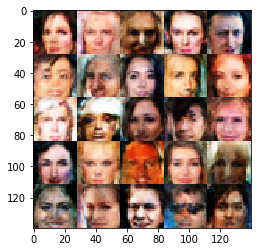

Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 2.2834
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.7105


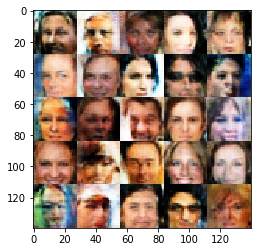

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.